In [1]:
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
epochs = 25
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

In [3]:
image_files = [f for f in glob.glob(r'C:/Users/91890/Downloads/Gender-Detection-master/Gender-Detection-master/gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

In [5]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)


In [6]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

In [7]:
trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

In [8]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


In [9]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [10]:
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

In [11]:
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

C:\Users\91890\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

C:\Users\91890\AppData\Local\Temp\ipykernel_26900\3811416611.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),


Epoch 1/25
28/28 [==============================] - 22s 739ms/step - loss: 0.8354 - accuracy: 0.6873 - val_loss: 0.7151 - val_accuracy: 0.5173
Epoch 2/25
28/28 [==============================] - 21s 759ms/step - loss: 0.5278 - accuracy: 0.7934 - val_loss: 0.6698 - val_accuracy: 0.5671
Epoch 3/25
14/28 [==============>...............] - ETA: 10s - loss: 0.4864 - accuracy: 0.8237

KeyboardInterrupt: 

In [13]:
# save the model to disk
model.save('gender_detection_.model')

INFO:tensorflow:Assets written to: gender_detection_.model\assets


INFO:tensorflow:Assets written to: gender_detection_.model\assets


KeyError: 'acc'

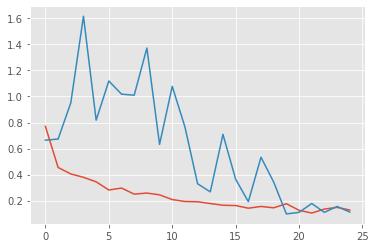

In [16]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import cvlib as cv

In [14]:
model = load_model('gender_detection.model')

In [15]:
webcam = cv2.VideoCapture(0)

In [16]:
classes = ['man','woman']

In [17]:
while webcam.isOpened():

    # read frame from webcam 
    status, frame = webcam.read()

    # apply face detection
    face, confidence = cv.detect_face(frame)


    # loop through detected faces
    for idx, f in enumerate(face):

        # get corner points of face rectangle        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

        # crop the detected face region
        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (96,96))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        # apply gender detection on face
        conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)

    # display output
    cv2.imshow("gender detection", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release resources
webcam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 32ms/step
